# Assignment Part 2: Segmentation of Human Blood Cells using Convolutional Neural Networks
_By David Holmberg (2023)_

Welcome to Task 3! In this assignment you will segment Leukocytes using both scratch-built models and  pre-defined downloaded models.

Hand-in: this notebook or a pdf of it.

For this lab, we use the [Human White Blood Cell images](https://github.com/zxaoyou/segmentation_WBC) from [Jiangxi Tecom Science Corporation, China](http://en.tecom-cn.com/).

The dataset contains three hundred 120x120 RGB images with one blood cell per image, and corresponding segmentation masks. The segmentation mask was manually sketched by domain experts, with the background, cytoplasms and nuclei pixels labelled as 0, 1 and 2 respectively.

<img src="Illustrations/Dataset_1.png" title="Blood cells dataset" align="left"/>






These images and masks are in the **LabData/bloodcells_seg/** folder:
```
└── LabData
    └── bloodcells_seg
        ├── masks
        │   ├── all
        └── images
            ├── all
```

We want to use convolutional neural networks to do pixel-wise classification of these blood cells images into background / cytoplasm / nuclei.

This assignment is based on and borrows *heavily* from a lab written by Christophe Avenel at NBIS, and his code is available here: https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/tree/master/session_convolutionalNeuralNetworks/Labs

So please remember that he is the original author of this assignment.

In [2]:
# First we import useful modules like numpy and Keras layers

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# cnn_helper contains some useful functions for this lab
import cnn_helper
from IPython.display import IFrame
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
os.environ["SM_FRAMEWORK"]="tf.keras"
import segmentation_models as sm


2024-01-28 19:43:55.205164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


We will load both the images and the masks as generators, and combine both generators into a zip of generators.

In [3]:
IMG_SIZE = 128
NUM_CLASSES = 3 # Background, cytoplasm, nuclei
N_CHANNELS = 3  # R,G,B
BATCH_SIZE = 8  # You can tune this and see which batch size runs faster / gives the best accuracy.


train_steps = 240/BATCH_SIZE
val_steps = 64/BATCH_SIZE


seed = 909 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255 #We need to rescale png images from 0-255 integers to 0.0-1.0 floats.
)
mask_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Load image and mask generators for training:
train_image_generator = image_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/images/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None, 
    seed=seed,
    subset='training',
    color_mode='rgb',
    shuffle=False)
# Note: the class_mode is used when the class is extracted from the directory
# structure. Here the class will be defined by the mask from the generator below, 
# so we add class_mode: None

train_mask_generator = mask_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/masks/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='training',
    color_mode='grayscale',
    shuffle=False)

train_generator = zip(train_image_generator, train_mask_generator)

# Load image and mask  generators for validation:
val_image_generator = image_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/images/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='validation',
    color_mode='rgb',
    shuffle=False)

val_mask_generator = mask_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/masks/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='validation',
    color_mode='grayscale',
    shuffle=False)

val_generator = zip(val_image_generator, val_mask_generator)

Found 240 images belonging to 1 classes.
Found 240 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.


We can now check that the generators deliver our data:

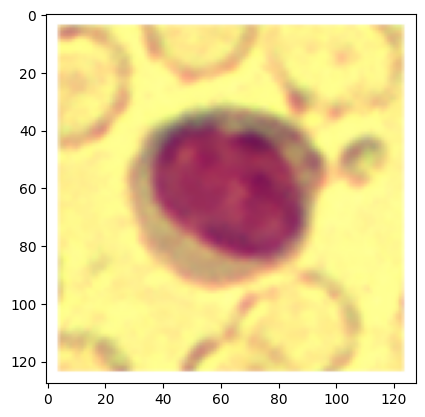

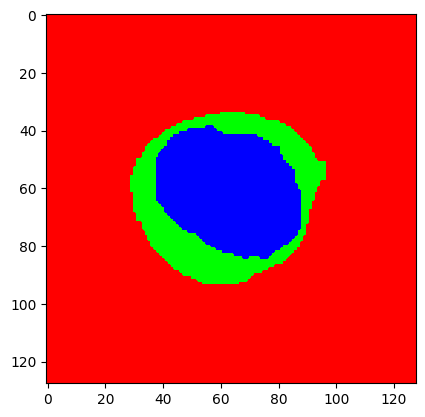

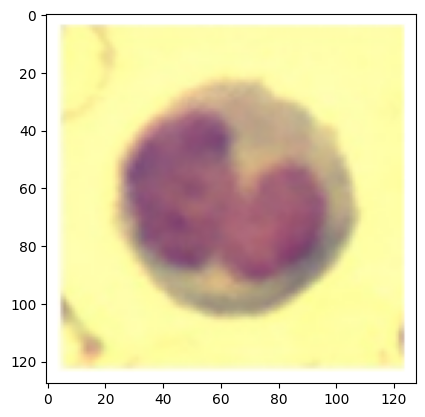

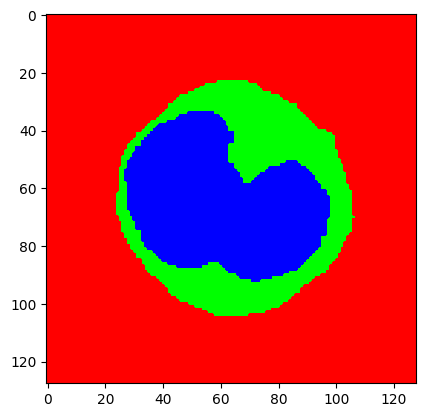

In [4]:
cMap = ListedColormap(['red', 'lime', 'blue'])

images,masks = next(train_generator)
for i in range(0,2):
    plt.figure()
    plt.imshow(images[i], cmap=cMap)
    plt.figure()
    plt.imshow(masks[i,:,:,0], cmap=cMap)


For this assignment you will build a UNET model. You can see an illustration of the model below, and we have provided a base model for you to tweak, as it must still comply with the data we have provided.

<img src="Illustrations/unet.png" title="Unet model"/>


In [5]:
inputs = layers.Input((IMG_SIZE, IMG_SIZE, N_CHANNELS))

c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = layers.Dropout(0.1) (c1)
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = layers.Dropout(0.1) (c2)
c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = layers.Dropout(0.2) (c3)
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = layers.Dropout(0.2) (c4)
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = layers.Dropout(0.3) (c5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = layers.Dropout(0.2) (c6)
c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = layers.Dropout(0.2) (c7)
c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = layers.Dropout(0.1) (c8)
c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = layers.Dropout(0.1) (c9)
c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax') (c9)


# def conv_block(x, filters, kernel_size=3, activation='relu', padding='same', dropout_rate=0.1):
#     c = layers.Conv2D(filters, (kernel_size, kernel_size), activation=activation, kernel_initializer='he_normal', padding=padding)(x)
#     c = layers.Dropout(dropout_rate)(c)
#     c = layers.Conv2D(filters, (kernel_size, kernel_size), activation=activation, kernel_initializer='he_normal', padding=padding)(c)
#     p = layers.MaxPooling2D((2, 2))(c)
#     return c, p

# def upconv_block(x, skip, filters, kernel_size=3, activation='relu', padding='same', dropout_rate=0.1):
#     u = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
#     u = layers.concatenate([u, skip])
#     c = layers.Conv2D(filters, (kernel_size, kernel_size), activation=activation, kernel_initializer='he_normal', padding=padding)(u)
#     c = layers.Dropout(dropout_rate)(c)
#     c = layers.Conv2D(filters, (kernel_size, kernel_size), activation=activation, kernel_initializer='he_normal', padding=padding)(c)
#     return c

# IMG_SIZE = 128
# N_CHANNELS = 3
# NUM_CLASSES = 3  # Change this to the number of segmentation classes

# inputs = layers.Input((IMG_SIZE, IMG_SIZE, N_CHANNELS))
# x = inputs

# # Encoder (Contracting Path)
# conv_blocks = []
# for filters in [16, 32, 64, 128, 256]:
#     x, p = conv_block(x, filters)
#     conv_blocks.append(p)

# # Bottleneck
# x = conv_block(x, 512, dropout_rate=0.3)

# # Decoder (Expansive Path)
# for i, filters in enumerate([256, 128, 64, 32, 16]):
#     x = upconv_block(x, conv_blocks[-(i + 1)], filters)

# # Output
# outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(x)


2024-01-28 19:43:58.510757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19467 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c2:00.0, compute capability: 8.6


We will use the Keras SparseCategoricalCrossentropy loss function (see https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

because our ground truth is represented by integers on a mask (0 for background, 1 for cytoplasm, 2 for nuclei pixels) this becomes a good choice.

Please define, summarize, and compile it in the following three cells:

**tip:** you'll want to define the loss specifically, i.e use tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) and not 'SparseCategoricalCrossentropy' as before.

**tip:** you can define the learning rate specifically in Adam() inside the parenthesis. I suggest you start with 0.0001.

In [6]:
model = keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=Adam(
    learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

### NOTE

While Relu is considered fairly standard to use, you can try replacing it with selu, gelu, elu, relu6, LeakyRelu. WIth most of these, it is enough to just replace 'relu'. However, LeakyRelu requires a bit of extra code. Search for it if you want to try it!

## train
Now you will train the network.

Look back at how you trained your model in the previous Assignment.

You can track the progress of your training using the callback function we've defined for you in the cell below. you can do this by adding ```callbacks=[plot_callback]``` at the end of your model.fit_generator function.

In [7]:
#train the network:
epochs = 20

plot_callback = cnn_helper.PlottingKerasCallback(
    test_batch=next(val_generator),
    num_plot=3 # how many validation examples to plot at each epoch (maximum = BATCH_SIZE)
)

model.fit_generator(
    generator=train_generator,
    steps_per_epoch= train_steps,
    validation_data= val_generator,
    validation_steps= val_steps,
    epochs= epochs,
    #callbacks=[plot_callback]
)

# model.fit(
#     generator=train_generator,
#     steps_per_epoch=train_steps, 
#     epochs=Epochs,
#     validation_data=val_generator,
#     validation_steps=val_steps,
#     callbacks=[plot_callback]
# )

Epoch 1/20


/tmp/ipykernel_64341/227791923.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
2024-01-28 19:43:59.157022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-28 19:44:00.937248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-28 19:44:01.354334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-28 19:44:02.329221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] T

29/30 [============================>.] - ETA: 0s - loss: 1.0231 - accuracy: 0.5214

2024-01-28 19:44:09.035759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 11s 42ms/step - loss: 1.0122 - accuracy: 0.5357 - val_loss: 0.7193 - val_accuracy: 0.9850
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5241 - accuracy: 0.9670 - val_loss: 0.4608 - val_accuracy: 0.9898
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4075 - accuracy: 0.9064 - val_loss: 0.3960 - val_accuracy: 0.8769
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3671 - accuracy: 0.8426 - val_loss: 0.3533 - val_accuracy: 0.8331
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3113 - accuracy: 0.7789 - val_loss: 0.2996 - val_accuracy: 0.7998
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2446 - accuracy: 0.7473 - val_loss: 0.2656 - val_accuracy: 0.7912
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2035 - accuracy: 0.7325 - val_loss: 0.2472 - val_accuracy: 0.7845
Epoch 8/20
30/30 [=====

You can use the following cell to batch plot som validation. 


1/1 [==============================] - 0s 212ms/step


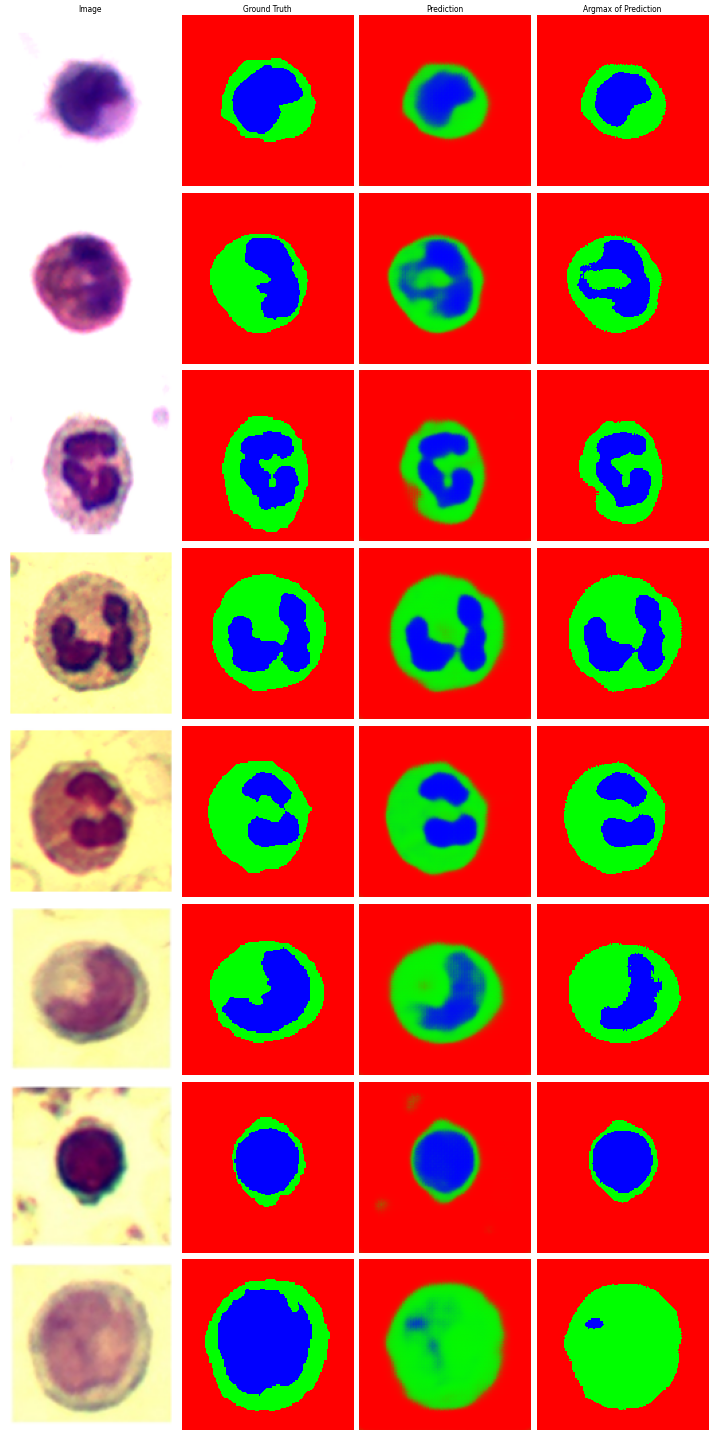

In [8]:
cnn_helper.plot_prediction(model, next(val_generator), BATCH_SIZE)

## Tuning of the model
Try improving on your model by changing the learning rate, epochs, activation function or any other parameters you want.


# Other models
Lets be honest, this was somewhat of a chore to code without GPT - and if you did use GPT and got it to work, it's still a bit a work, no? We can be even lazier, and use predfined models to simplify the construction of your models.

you will now use the `segmentation_model` python library ( it should be installed already, but if you get an error, install using `pip install segmentation_model`).
 
You can read more about the `segmentation_model` library at https://github.com/qubvel/segmentation_models.

## List of relevant models:

| Unet | Linknet |
| --- | --- |
| <img width="500px" src="https://raw.githubusercontent.com/qubvel/segmentation_models/master/images/unet.png" title="UNet"/> | <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/linknet.png" title="Linknet"/> |



## List of backbones:

| Type | Names |
| --- | --- |
| VGG | `vgg16` `vgg19` |
| ResNet | `resnet18` `resnet34` `resnet50` `resnet101` `resnet152` |
| SE-ResNet | `seresnet18` `seresnet34` `seresnet50` `seresnet101` `seresnet152` |
| ResNeXt | `resnext50` `resnext101` |
| SE-ResNeXt | `seresnext50` `seresnext101` |
| SENet154 | `senet154` |
| DenseNet | `densenet121` `densenet169` `densenet201` |
| Inception | `inceptionv3` `inceptionresnetv2` |
| MobileNet | `mobilenet` `mobilenetv2` |
| EfficientNet | `efficientnetb0` `efficientnetb1` `efficientnetb2` `efficientnetb3` `efficientnetb4` `efficientnetb5` `efficientnetb6` `efficientnetb7` |

Now try repeating the segmentation using a combination of either UNET or LinkNet with one of the backbones.


In [9]:
# Let's load the Unet model, using the VGG16 backbone
model = sm.Unet(
    'vgg16',
    encoder_weights=None,
    classes=NUM_CLASSES,
    activation='softmax',
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)


In [10]:
#Print the model summary:

### Define, Compile, and Train the new model:

You will now define, compile, and train the new model you selected from the module with the same parameters as your best run with your self-built model.



In [11]:
#compile here:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [12]:
#train model here:
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_steps, 
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_steps, 
)

Epoch 1/30


/tmp/ipykernel_64341/2555264483.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
2024-01-28 19:44:22.235143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/30 [===========================>..] - ETA: 0s - loss: 0.6353 - accuracy: 0.7383

2024-01-28 19:44:33.236734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 12s 63ms/step - loss: 0.6235 - accuracy: 0.7379 - val_loss: 0.9154 - val_accuracy: 1.0000
Epoch 2/30
30/30 [==============================] - 1s 28ms/step - loss: 0.4180 - accuracy: 0.7390 - val_loss: 0.7475 - val_accuracy: 1.0000
Epoch 3/30
30/30 [==============================] - 1s 28ms/step - loss: 0.3122 - accuracy: 0.7390 - val_loss: 0.6616 - val_accuracy: 0.9985
Epoch 4/30
30/30 [==============================] - 1s 29ms/step - loss: 0.2394 - accuracy: 0.7339 - val_loss: 0.6663 - val_accuracy: 0.9636
Epoch 5/30
30/30 [==============================] - 1s 28ms/step - loss: 0.1909 - accuracy: 0.7307 - val_loss: 0.5595 - val_accuracy: 0.9154
Epoch 6/30
30/30 [==============================] - 1s 28ms/step - loss: 0.1618 - accuracy: 0.7294 - val_loss: 0.4358 - val_accuracy: 0.8700
Epoch 7/30
30/30 [==============================] - 1s 29ms/step - loss: 0.1372 - accuracy: 0.7284 - val_loss: 0.2742 - val_accuracy: 0.7864
Epoch 8/30
30/30 [=====

1/1 [==============================] - 0s 235ms/step


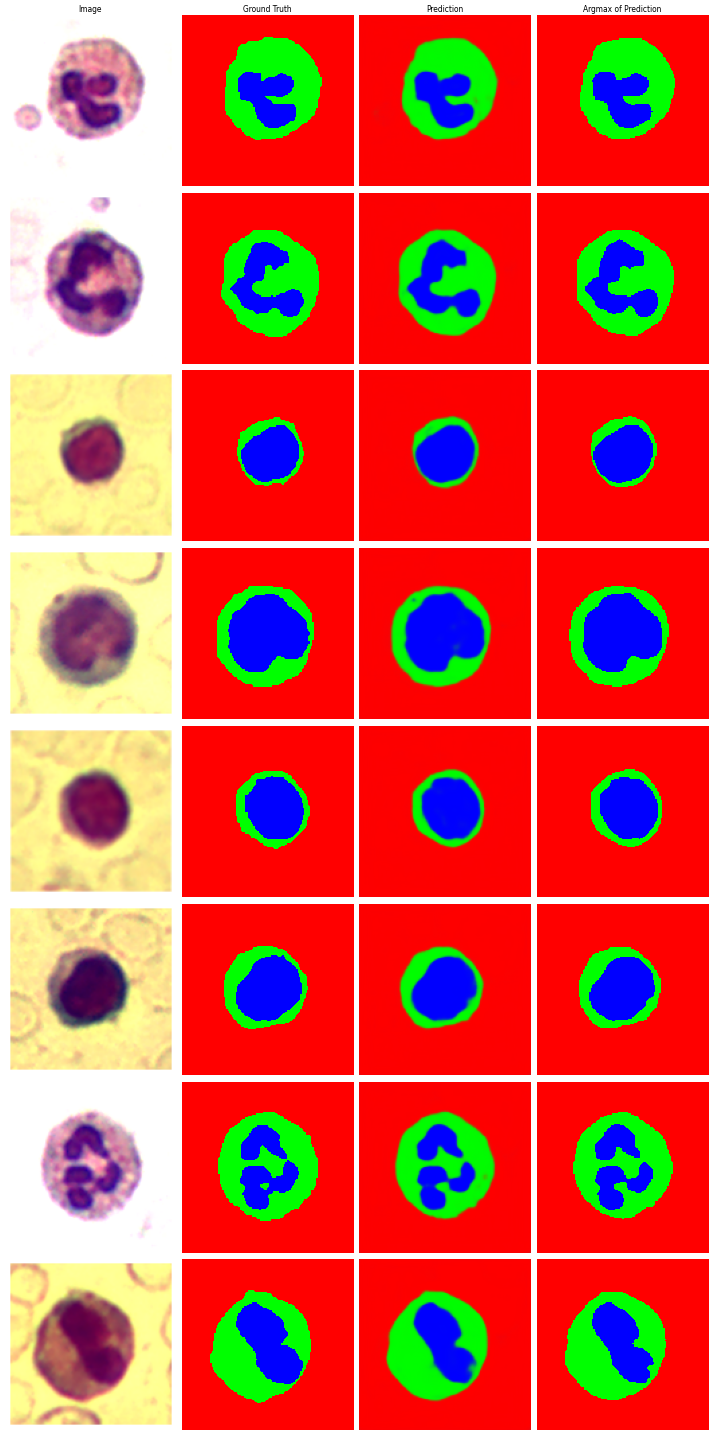

In [13]:
#Print prediction the same way as before:

cnn_helper.plot_prediction (model, next(val_generator), BATCH_SIZE)

## End of Assignment 3b:

And this is how image segmentation is done. I hope you enjoyed this brief introduction, and encourage you to play around and test multiple models, both predefined and scratch-build.